In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rc('image', cmap='gray')
mpl.rc('figure', dpi=150)

Работать с изображением будем с помощью `OpenCV`, а отображать -- с помощью `matplotlib`, так как `OpenCV` не работает в `jupyter`. `OpenCV` работает в формате `BGR`, а `matplotlib` -- в формате `RGB`, поэтому требуется преобразование с помощью функции `cv2.cvtColor`.
Будем использовать классическое тестовое изображение.

In [3]:
img = cv2.imread('Lenna_(test_image).png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

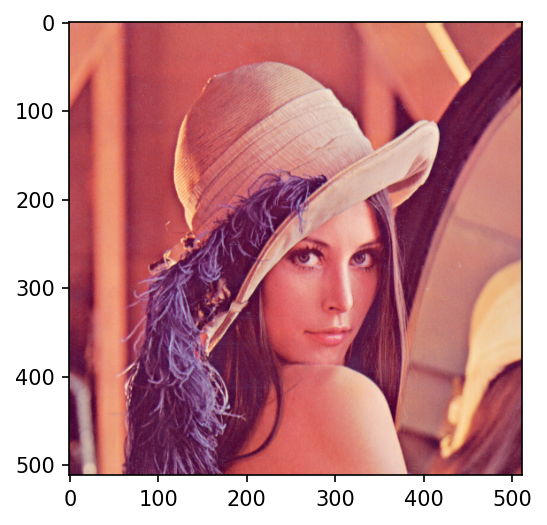

In [4]:
plt.imshow(img)

Основная интегральная характеристика изображения --- гистограмма каналов (в фотошопе это кривые). 
Это распределение числа пикселей, которые имеют то или иное значение интенсивности цветового канала.

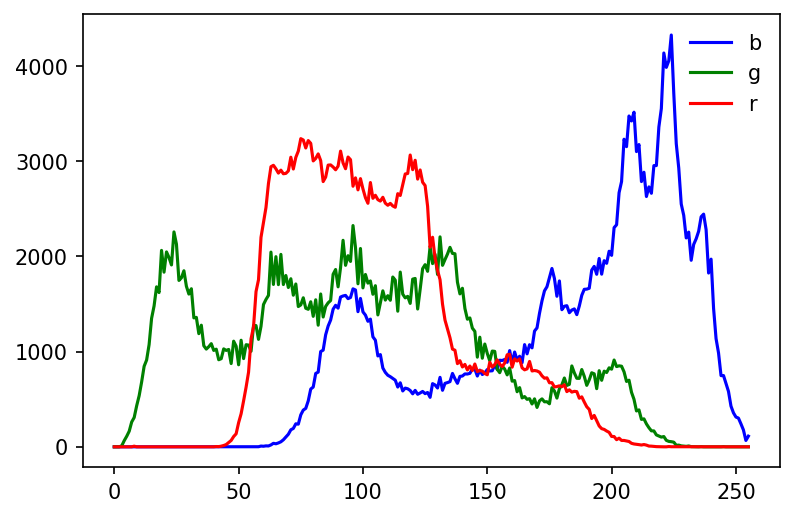

In [5]:
colors = 'bgr'
for i in range(3):
    plt.plot(cv2.calcHist([img],[i],None,[256],[0,256]), color=colors[i], label=colors[i])
plt.legend(frameon=False)
plt.show()

Для удобства работы с яркостью изображения удобнее использовать не "обычное" `RGB` пространство, а пространство, где яркость выведена в отдельный канал. 
Примером такого пространства является `HSV`: Hue --- тон, Saturation --- насыщенность, Value --- значение (яркость).
Для преобразования изображений между цветовыми пространствами в `OpenCV` есть функция `cvtColor` с множеством вариантов преобразования.

In [6]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

Канал `Value` будет, по сути, изображением в градациях серого

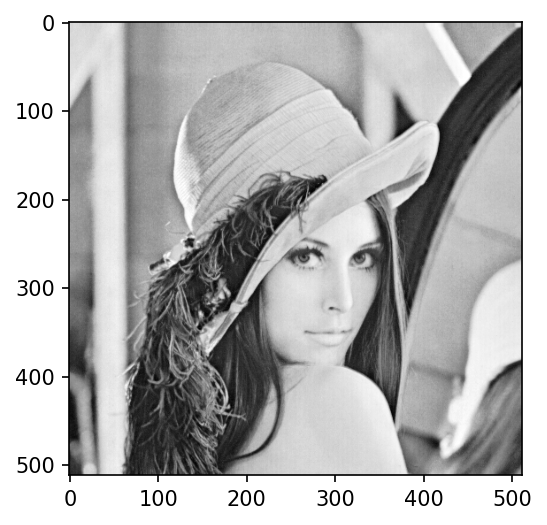

In [7]:
plt.imshow(img_hsv[:, :, 2], vmax=255)

Гистограммы каналов существенно отличаются в силу иной физической природы значений в каналах

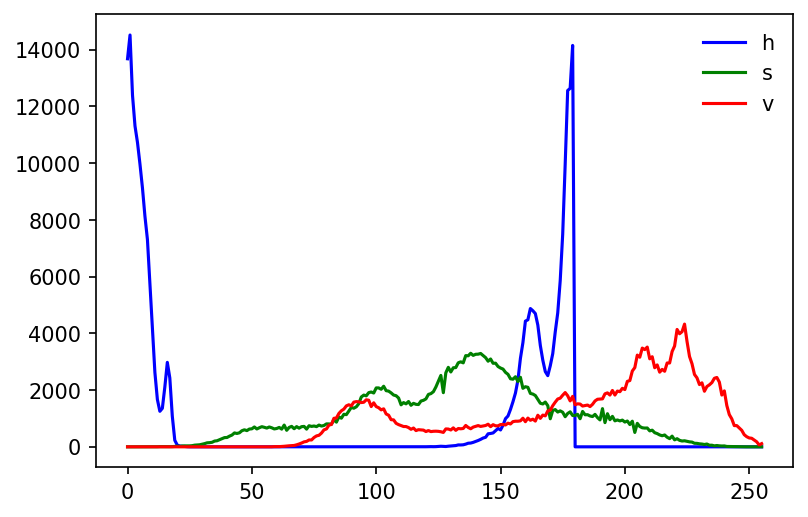

In [8]:
colors = 'bgr'
chs = 'hsv'
for i in range(3):
    plt.plot(cv2.calcHist([img_hsv],[i],None,[256],[0,256]), color=colors[i], label=chs[i])
plt.legend(frameon=False)
plt.show()

Цветовые пространства, в которых под яркость или эквивалентную характеристкиу выведен отдельный канал удобны для настройки яркости и контрастности изображений по простой формуле:
`V' = a * V + b`
Где коэффициент `a` отвечает за контраст, то есть разницу между минимумом и максимумом, а `b` --- за базовый уровень яркости.
Например, по гистограммам выше можно видеть, что можно повысить контраст изображения, если сдвинуть канал `V` на -50 и растянуть до 255, то есть умножить на `255 / 205 = 1.244`. Разница видна невооруженным глазом!

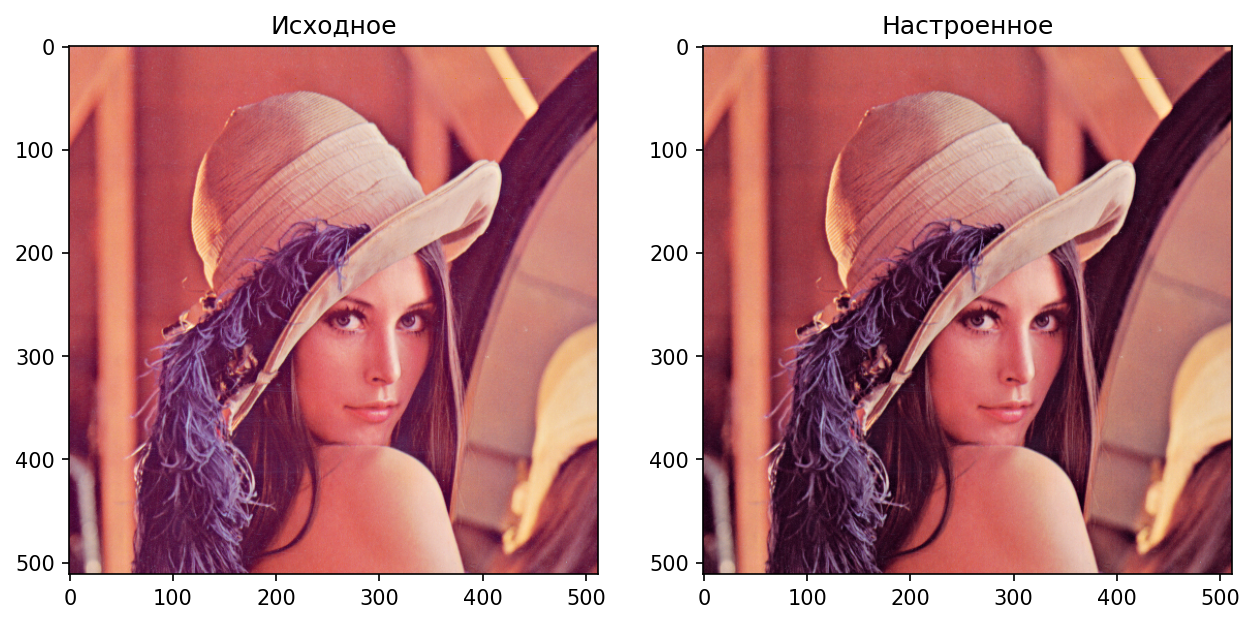

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img_hsv_new = img_hsv.copy()
img_hsv_new[:, :, 2] = 1.244 * (img_hsv[:, :, 2] - 50)
img_rgb_new = cv2.cvtColor(img_hsv_new, cv2.COLOR_HSV2RGB)
ax[0].set_title("Исходное")
ax[0].imshow(img)
ax[1].set_title("Настроенное")
ax[1].imshow(img_rgb_new)

Другой вариант цветового пространства с яркостью в отдельном канале --- `YUV` или `YCrCb`, где первый канал `Y` --- яркость, а два других --- цвета в нелинейном пространстве от красного до зеленого `Cr` и от синего до желтого `Cb`

In [23]:
img_ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

В этом цветовом пространстве также можно сделать настройку контраста и яркости изображения.

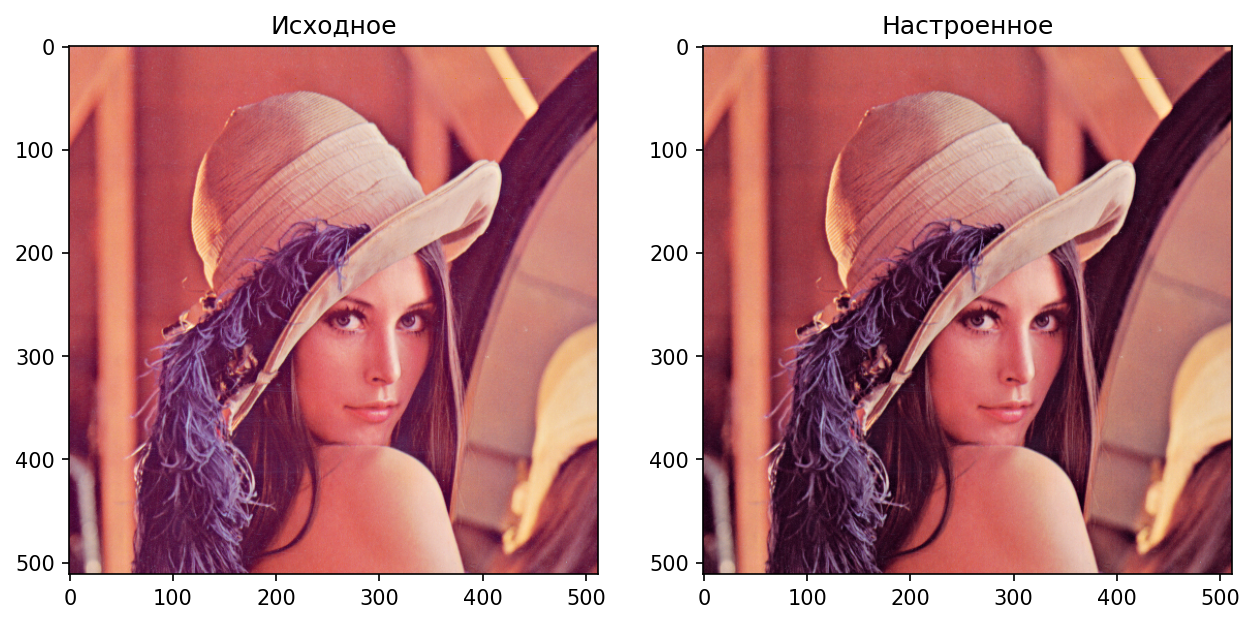

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img_ycrcb[:, :, 0] = 1.244 * (img_ycrcb[:, :, 0] - 50)
img_rgb_new = cv2.cvtColor(img_hsv_new, cv2.COLOR_HSV2RGB)
ax[0].set_title("Исходное")
ax[0].imshow(img)
ax[1].set_title("Настроенное")
ax[1].imshow(img_rgb_new)

Гистограммы в пространстве `YUV` показывают общий тон изображения, видно, что изображение в плане цвета достаточно однородно, как говорится, имеет определенную палитру.

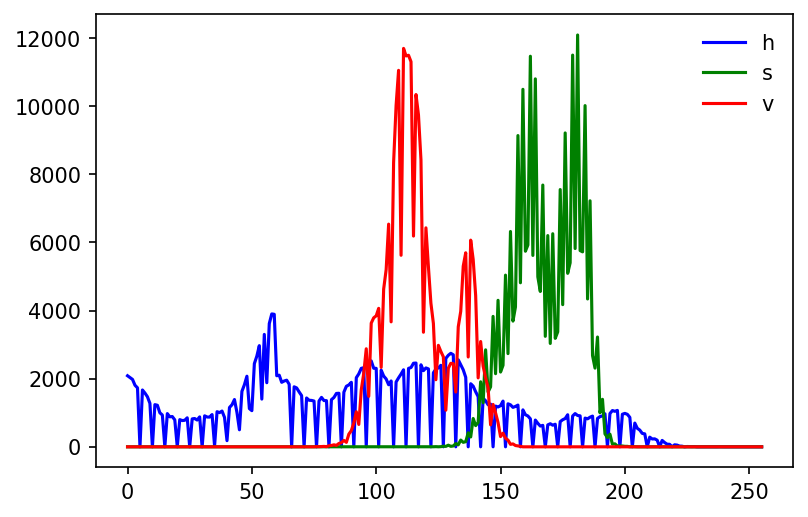

In [27]:
colors = 'bgr'
chs = 'hsv'
for i in range(3):
    plt.plot(cv2.calcHist([img_ycrcb],[i],None,[256],[0,256]), color=colors[i], label=chs[i])
plt.legend(frameon=False)
plt.show()

Видно, что гистограмма яркости сильно изрезана. Это получается из-за того, что мы воспользовались простым афинным преобразованием (растяжение + сдвиг), из-за чего соседние точки стали располагаться дальше друг от друга. Аналогичную процедуру, но уже автоматически, производит встроенная в `cv2` функция `equalizeHist`

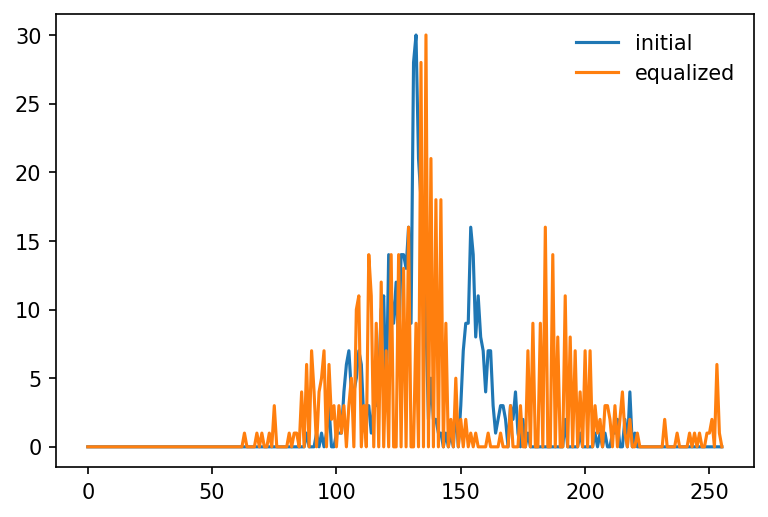

In [30]:
img_ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
lum = img_ycrcb[:, :, 0].copy()
hist = cv2.calcHist(lum, [0], None, [256], [0, 255])
plt.plot(hist, label='initial')

lum = cv2.equalizeHist(img_ycrcb[:, :, 0].astype(np.uint8))
hist = cv2.calcHist(lum, [0], None, [256], [0, 255])
plt.plot(hist, label='equalized')
plt.legend(frameon=False)

Альтернативным подходом является локальная эквализация гистограммы, `CLAHE`, когда изображение делится на блоки и гистограмма оптимизируется внутри них. Благодаря этому сохраняется локальный контраст изображения. Для этого требуется создать эквалайзер с помощью `createCLAHE`

In [18]:
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(16, 16))

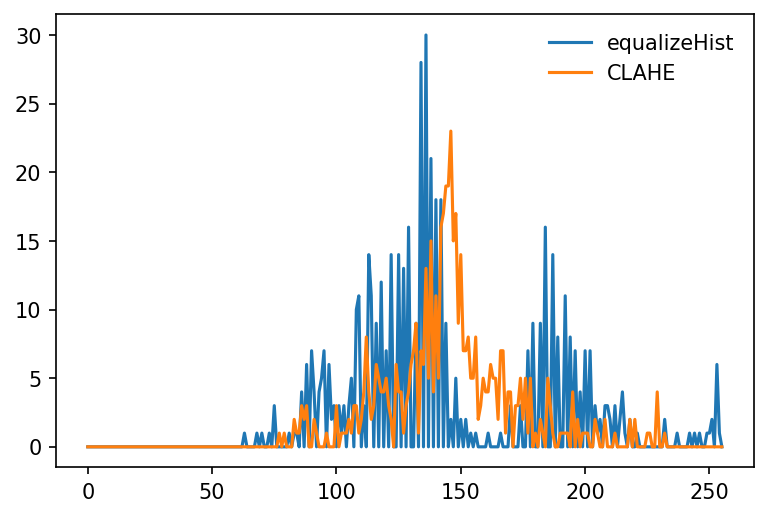

In [32]:
lum_s = cv2.equalizeHist(img_ycrcb[:, :, 0].astype(np.uint8))
hist = cv2.calcHist(lum_s, [0], None, [256], [0, 255])
plt.plot(hist, label='equalizeHist')
lum = clahe.apply(img_ycrcb[:, :, 0].astype(np.uint8))
hist = cv2.calcHist(lum, [0], None, [256], [0, 255])
plt.plot(hist, label='CLAHE')
plt.legend(frameon=False)

Если сравнить результаты эквализации, то разница видна невооруженным глазом. `CLAHE` сохранил локальный контраст, благодаря чему мы избежали пересветов изображения

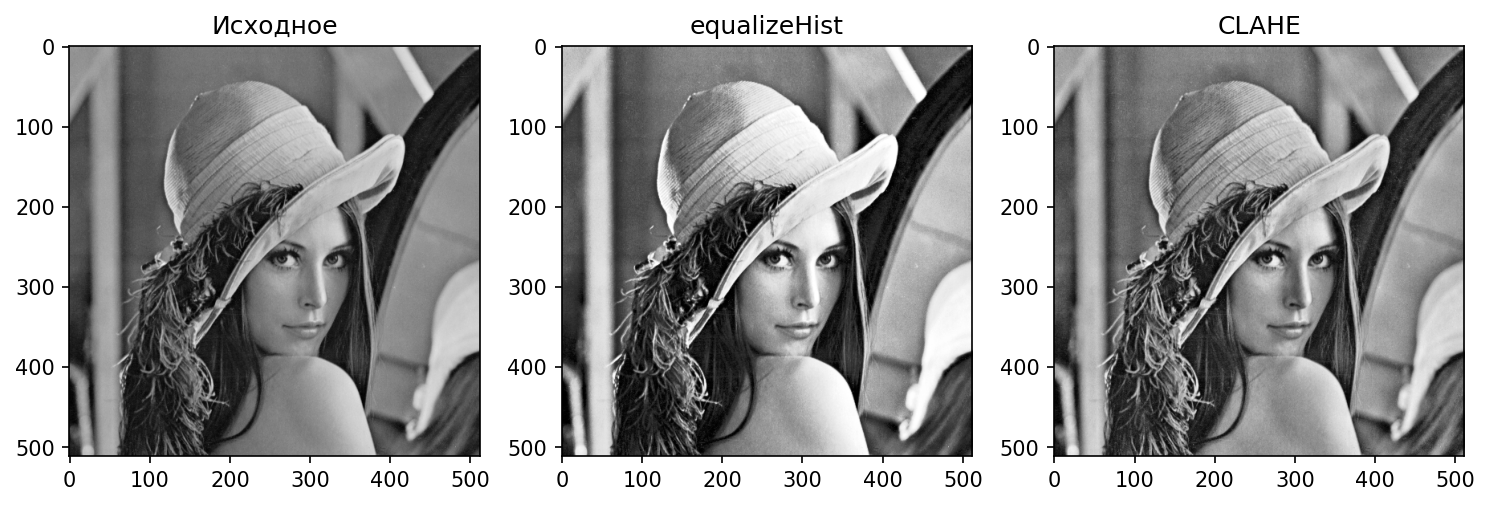

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].set_title("Исходное")
ax[0].imshow(img_ycrcb[:, :, 0], vmax=255)
ax[1].set_title("equalizeHist")
ax[1].imshow(lum_s, vmax=255)
ax[2].set_title("CLAHE")
ax[2].imshow(lum, vmax=255)

Помимо настройки яркости/контраста изображения существует проблема баланса белого, то есть естественности цветов изображения. Для его настройки в `cv2` есть класс эквалайзера в опциональном (ставится отдельно) модуле `cv2.xphoto`. Например, баланс белого можно настраивать с помощью `createGrayworldWB`. Это оптимальный по простоте и скорости использования вариант.

In [21]:
wb = cv2.xphoto.createGrayworldWB()
wb.setSaturationThreshold(0.7)

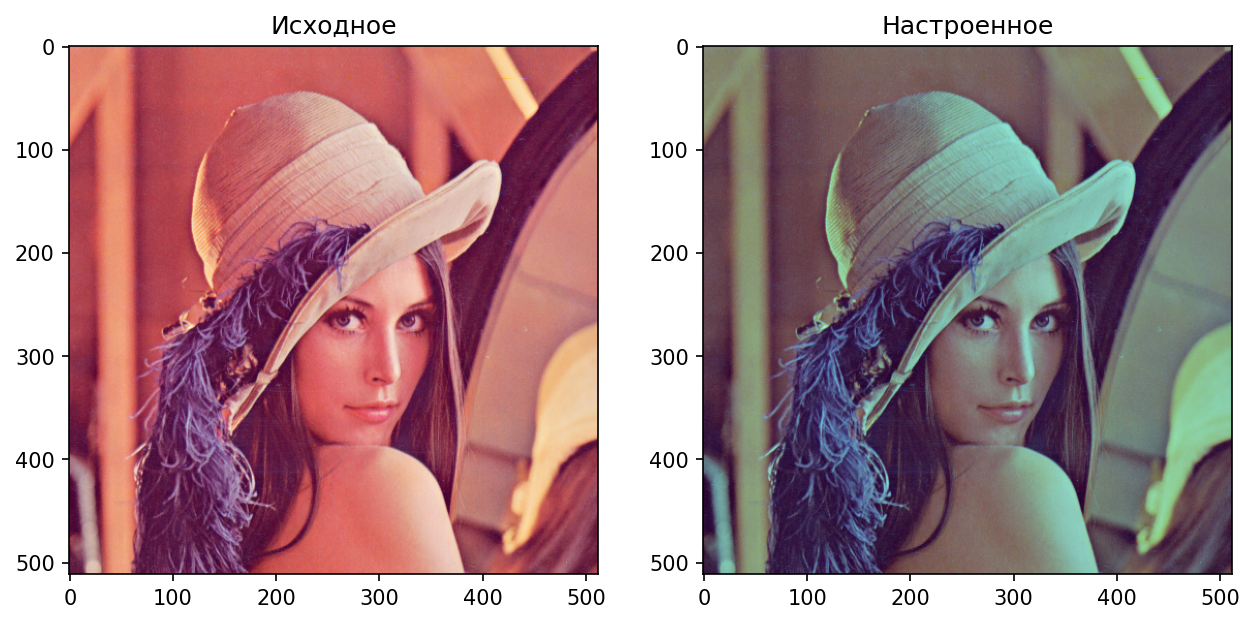

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("Исходное")
ax[0].imshow(img)
ax[1].set_title("Настроенное")
ax[1].imshow(wb.balanceWhite(img), vmax=255)